There are two goals for this notebook. First, make all simulations and modeling choices used in Halleran, Flores-Bautista and Murray, 2019 clear to the reader. Second, enable easy simulations of different parameter sets or conditions for future study and analysis. 

Briefly, this code can perform stochastic simulations of a Moran process of evolution where individual cells contain a population of plasmids. Individual plasmids can be wildtype or mutant. Individual plasmids mutate at a defined mutation rates. Cells grow differentially based on the number of mutant vs. wildtype plasmids they have. 

At cell division plasmids can randomly partition into daughter cells (random plasmid partitioning), or the two daughter cells can have the exact same distributuon of wildtype vs. mutant plasmids (perfect partitioning). This random partitioning process is simulated using a hypergeometric distribution, inspired by actively partitioned plasmids such as pSC101. 

In [1]:
# All import statements. This should only require Anaconda to run correctly. 
import collections
import bisect
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import numba
import time
import multiprocessing
from scipy.stats import hypergeom
import re

# This is just a bit of formatting for our plots to make them look a bit nicer than 
# the default 
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
tw = 1.5
sns.set_style({"xtick.major.size": 6, "ytick.major.size": 6,
               "xtick.minor.size": 4, "ytick.minor.size": 4,
               'axes.labelsize': 24,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize= 21) 
mpl.rc('ytick', labelsize= 21)
mpl.rc('axes', linewidth=1.75)
# Setting this font type allows the figure object to be edited in Illustrator / Affinity 
# to change font size, color, etc. 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 30})

# This enables high res graphics inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def get_tau(percentages, timepoints):
    ''' Requires percentages and timepoints. Returns the time when the fully 
        engineered cells reach <= 50% of the population. '''
    
    # Get the index at which the fully engineered cells reach 50%
    ind = bisect.bisect_left(list((np.round(percentages[:,:,0].mean(axis = 0)))[::-1]),
                             50)
    
    # Reverse timepoints
    timepoints = list(timepoints)[::-1]  
    
    # Check to see if we never found a time when it crossed the halfway point. This 
    # corresponds to a case where the mutants never take over the population 
    if ind == 0:
        tau = 0
    else:
        tau = timepoints[ind]
        
    # return the time at which the fully engineered cells reach <= 50% of the population 
    return tau

def get_omega(percs, timepoints, number_of_states):
    """Requires percentages, timepoints, and the number of states. 
    Returns omega, the time until half the plasmids in the population
    are broken."""
    
    # Generates a 1D array where number_broken_plasmids[i] = the number of plasmids
    # broken in percs[i]. For example, the first population in percs[i] is the fully
    # unbroken state, so number_broken_plasmids[i] = 0. The next state, percs[1],
    # corresponds to the one broken plasmid state and number_broken_plasmids[1] = 1.
    number_broken_plasmids = np.arange(0, number_of_states)
    
    # Get the mean percentage percentage for each individual simulations percentages.
    mean_percentages = percs[:,:,:].mean(axis=0)
    
    # Multiply by the number of broken plasmids in each state, take the sum, and then
    # divide by the copy number of the plasmid. This is just doing a weighted average. 
    broken_percs = np.sum(mean_percentages * number_broken_plasmids, axis=1) / (number_of_states-1)
    
    # Round the broken percentages just to make it easy to use bisect below
    percs = np.round(broken_percs)

    # find where percentages cross over 50
    ind = bisect.bisect_left(percs, 50)
    
    # If it never crosses over return 0 to indicate we don't know where omega occurs
    if ind == len(timepoints):
        omega = 0
    # otherwise, return the timepoint at which you crossed over 
    else: 
        omega = timepoints[ind]
        
    return omega

def get_gamma(percentages, timepoints):
    '''Requires percentages and timepoints. 
    Returns gamma, the time until the fully broken cells reach 50% of the population'''
    
    # Similar to tau, get the index at which the final state (entirely mutant plasmids)
    # reaches 50% of the population 
    ind = bisect.bisect_left(list((np.round(percentages[:,:,
            (np.shape(percentages)[2]-1)].mean(axis = 0)))), 50)
    
    # If the fully mutated state never reaches 50%, return 0.
    if ind == len(timepoints):
        gamma = 0
    # Otherwise, return the timepoint at which you crossed over
    else: 
        gamma = timepoints[ind]
        
    return gamma

def get_percentages(pops, n_simulations, timepoints, number_of_states): 
    '''This function requires the population timecourse output from
        the stochastic simulation, the number of simulations ran, 
        the timepoints, and the number of states in the model. 
        It uses this information to convert the population count data to population 
        fraction data.'''
    
    # Initialize an empty array called ratios. This is where we will store 
    # The ratios of each population relative to the sum of the population at that
    # timepoint. It has dimensions of ((n_simulations, len(time_points), number_of_states)).
    ratios = np.zeros((n_simulations, len(time_points), number_of_states))
    
    # Iterate over each simulation
    for j in range(n_simulations):
        # Iterate over each time point
        for i in range(len(timepoints)):
            # Fill in the ratio array with the population array at that timepoint divided
            # by the total population size at that timepoint
            ratios[j][i][:] = pops[j][i][:] / np.sum(pops[j][i][:])
        
    # To convert ratios to percentages simply multiply by 100
    percentages = ratios*100
    percentages = np.where(np.isnan(percentages), 0, percentages)
    # Return percentages
    return percentages

In [3]:
def plot_timecourse_stochastic_pops(pops, number_of_states, n_simulations, time):
    '''Requires pops, number of states, number of simulations, and the timepoints used
    for simulation. Plots the populations of cells with different numbers of 
    mutant plasmids as a function of time. '''
    
    # Picks the sns color palette purple with the appropriate number of colors
    palette = sns.color_palette("Purples", n_colors = number_of_states)
    
    # Initialize figure size
    plt.figure(figsize=(8,6))
    
    # Iterate over each state
    for i in range(0, number_of_states) :
        # Iterate over each simulation
        for j in range(n_simulations):
            # Plot each individual trace in a thin linewidth with alpha
            plt.plot(time, pops[j,:,i], lw = 1, alpha = 0.7, color=palette[i])
            
        # Plot the mean for that state across all simulations in a thicker linewidth
        plt.plot(time, pops[:,:,i].mean(axis=0), lw = 3, label = '%s '%i + 'broken pl.', color=palette[i]) 

    # Format the output plot 
    plt.legend()
    plt.xlim(0,time[-1])
    plt.xlabel('Time (hours)', fontsize = 24)
    plt.ylabel('Population size', fontsize = 24)
    plt.tight_layout()
    plt.legend()  
    
def plot_percentages(percentages, time_points, number_of_states, colors):
    '''Requires percentages, time_points, number of states, and the colors to use
    for the palette. Plots the percentages of cells with different numbers of 
    mutant plasmids as a function of time.'''
    
    # Picks the sns color palette you pass with the appropriate number of colors. 
    palette = sns.color_palette(colors, n_colors = number_of_states)
    
    # Iterate over each simulation in percentages 
    for perc in percentages:
        percentages_sum = list(perc.sum(axis = 1))[::-1] #should add up to 100
        y = bisect.bisect(percentages_sum, 0)
        perc[len(time_points)-y: len(time_points)] = perc[len(time_points)-y-1]

    
    # Initialize the figure size. 
    plt.figure(figsize = (8,6))
    
    
    # Plot percentages for the engineered cells
    plt.plot(time_points[:], percentages[:,:,0].mean(axis = 0),  color = palette[0], 
                lw = 3, label = '0 mutated')
    
    y_err_eng = np.std(percentages[:,:,0], axis = 0)
    
    plt.fill_between(time_points[:], percentages[:,:,0].mean(axis=0) - y_err_eng,
                     percentages[:,:,0].mean(axis=0) + y_err_eng, alpha = 0.7, color=palette[0])
    
    #Plot percentages for the broken cells
    for i in range(1, number_of_states) :
        plt.plot(time_points[:], percentages[:,:,i].mean(axis = 0), color = palette[i],
                label = '%s '%i + 'mutated', lw = 3)
        
        y_err = np.std(percentages[:,:,i], axis = 0)
        plt.fill_between(time_points[:], percentages[:,:,i].mean(axis=0) - y_err,
                     percentages[:,:,i].mean(axis=0) + y_err, alpha = 0.7, color = palette[i])
            

    plt.xlabel('Time (hours)', fontsize = 20)
    plt.ylabel('Percent of population', fontsize = 20)
    plt.xlim(0, time_points[-1])
    plt.ylim(0, 105)
    plt.tight_layout()
    plt.legend()
    

In [4]:
# These next two functions, hypergeom_pmf_matrix and 
# generate_update_rule_from_pmf are the two most important to this specific model.

# hypergeom_pmf_matrix defines the partioning probabilities of mutant alleles into daughter
# cells upon cell division. 

# generate_update_rule_from_pmf is what generates the different possible updates in the
# stochastic simulation algorithm and their rates.  

def hypergeom_pmf_matrix(number_of_states):
    '''requires number_of_states. Returns the pmf_matrix according to 
    a hypergeometric distribution.'''
    
    # Initialize empty pmf list
    pmf_matrix = [] 
    
    # Generate an array ranging from 0 to number_of_states-1
    x = np.arange(0, number_of_states)
    
    # Fill the pmf_matrix with each individual pmf_vector according to the
    # different number of mutant plasmids. 
    for i in np.linspace(0, (number_of_states - 1)*2, number_of_states):
        rv = hypergeom((number_of_states - 1)*2, i, number_of_states - 1)
        pmf_vector = rv.pmf(x)
        pmf_matrix.append(pmf_vector)
    
    # Return the pmf matrix 
    return pmf_matrix

def generate_update_rule_from_pmf(pmf, growth_rates, mutation_rate, rand_partitioning):
    '''Requires the pmf (generated by hypegeom_pmf_matrix), growth_rate,
    mutation_rate, and rand_partitioning (True if there is random partitioning,
    False if there is perfect partitioning)'''
    
    # Initialize empty lists for all_updates and all_rates
    all_updates = []
    all_rates = []
    
    # If there is random partitioning: 
    if rand_partitioning == True:
        # Iterate over all entries in the 2D pmf matrix 
        for i in range(0, np.shape(pmf)[0]):
            for j in range (0, np.shape(pmf)[0]):
                
                # If there is a non-zero rate for the reaction
                if pmf[i][j] > 0:
                    if i == j: 
                        # If i==j then this is a growth reaction. Update rule is simple,
                        # 0s everywhere but a 1 on the i entry. 
                        empty_list = [0]*np.shape(pmf)[0]
                        empty_list[i] = 1
                        # Append the new list to all_updates
                        all_updates.append(empty_list)
                        # The rate is the pmf multiplied by the growth_rate
                        # Append that rate to all_rates
                        all_rates.append(pmf[i][j]*np.array(growth_rates[i]))
                    
                    # if i!=j, this is not a growth reaction but a partitioning 
                    # reaction. 
                    else:
                        # Find the difference between i and j. (How far are we moving)
                        difference = np.abs(i-j)
                        empty_list = [0]*np.shape(pmf)[0]
                        # Decrement the current population by 1
                        empty_list[i] = -1
                        # Increase the i-distance by 1, and the i+1 difference by 1
                        empty_list[i-difference] = 1
                        empty_list[i+difference] = 1
                        # Append the new list to all_updates
                        all_updates.append(empty_list)
                        # The rate is the pmf multiplied by the growth_rate because
                        # partitioning events are coupled to growth. Append that 
                        # rate to all_rates. 
                        all_rates.append(pmf[i][j]*np.array(growth_rates[i]))
                
                # If the reaction has zero probability of occuring then just add 0s to
                # all_rates and all_updates. 
                else:
                    all_updates.append([0]*np.shape(pmf)[0])
                    all_rates.append(0)

        # This loop adds the possibility of mutations occuring to the updates and 
        # rates. You simply move through the states scaled by the mutation rate. 
        # Note, mutation rate is not coupled to growth rate in our model. 
        for i in range(0, np.shape(pmf)[0]-1):
            empty_list = [0]*np.shape(pmf)[0]
            empty_list[i] = -1
            empty_list[i+1] = 1
            all_updates.append(empty_list)
            all_rates.append(mutation_rate*(np.shape(pmf)[0]-1-i))
        
    # If there is not random partitioning our life becomes much simpler. 
    else: 
        # Iterate over all entries in the 2D pmf matrix  
        for i in range(0, np.shape(pmf)[0]):
            for j in range (0, np.shape(pmf)[0]):
                # If there is a non-zero rate for the reaction
                if pmf[i][j] > 0:
                    if i == j: 
                        # If i==j then this is a growth reaction. Update rule is simple,
                        # 0s everywhere but a 1 on the i entry
                        empty_list = [0]*np.shape(pmf)[0]
                        empty_list[i] = 1
                        all_updates.append(empty_list)
                        all_rates.append(growth_rates[i])
                    
                    # In the no partitioning case off diagonal reactions cannot happen. 
                    else:
                        all_updates.append([0]*np.shape(pmf)[0])
                        all_rates.append(0)
                        
                # If the reaction has zero probability of occuring then just add 0s to
                # all_rates and all_updates.
                else:
                    all_updates.append([0]*np.shape(pmf)[0])
                    all_rates.append(0)

        # This loop adds the possibility of mutations occuring to the updates and 
        # rates. You simply move through the states scaled by the mutation rate. 
        # Note, mutation rate is not coupled to growth rate in our model. 
        for i in range(0, np.shape(pmf)[0]-1):
            empty_list = [0]*np.shape(pmf)[0]
            empty_list[i] = -1
            empty_list[i+1] = 1
            all_updates.append(empty_list)
            all_rates.append(mutation_rate*(np.shape(pmf)[0]-1-i))
    
    # convert all_updates to an array. 
    all_updates = np.array(all_updates)
    
    # Return all_updates and all_rates
    return all_updates, all_rates

def selection_mode_and_copy_number_to_growth_rates(selection_mode, burden, copy_number): 
    '''Requires selection_mode, burden, and copy_number. It then uses this information
    to generate an array of the appropriate growth rates.'''
    # If the selection mode is dominant the growth rates should follow the form of
    # the burden growth rate, then the unburdened growth rate over and over. 
    if selection_mode == 'dominant':
        growth_rates = np.array([1-burden] + [1]*(copy_number-1))
    # If the selection mode is additive, the growth rates should follow the form of
    # a linear increase with each successive mutation. 
    elif selection_mode == 'additive': 
        growth_rates = np.linspace(1 - burden, 1, copy_number)
    # If the selection mode is recessive, the growth rates should be the burdened growth
    # rate for each mutation until the cell has fully mutated plasmids, then it grows
    # at the unburdened growth rate. 
    elif selection_mode == 'recessive':
        growth_rates = np.array([1-burden]*(copy_number-1) + [1])
    else:
        print('No selection mode was picked')
        
    # Return all growth_rates. 
    return growth_rates

In [5]:
# Note - the following function is JIT'd - just in time compiled.
# This is essential for the speed of the simulations! The JIT'd code is much faster
# than standard python code.
@numba.jit(nopython=True)
def weighted_choice(weights):
    '''Takes a list where each entry is the number of cells in that population. 
    It then randomly picks one of the populations to delete a cell from, weighted by
    the number of cells in each bin. If there are two bins, one with 9 cells and one with
    1 cell, 90% of the time it will choose to decrement the bin with 9 cells.
    This is a key component of the Moran process simulation.'''
    # Get the cumulative sum
    cs = np.cumsum(weights)
    # Search sorted through the cumsum list
    choice = np.searchsorted(cs, np.random.random()*cs[-1])
    # Return the choice to decrement 
    return choice

# Note - the following function is JIT'd - just in time compiled.
# This is essential for the speed of the simulations! The JIT'd code is much faster
# than standard python code.
@numba.jit(nopython=True)
def get_propensities(concentrations, rates): 
    '''Takes concentrations and rates and returns the propensities.'''
    
    # Size is simply the number of different species in the simulation. 
    size = len(concentrations)
    
    # Initialize all_propensities. The total length is size**2 + size -1. 
    # The size**2 term comes from the main matrix of transitions where you can transition
    # from any state to any other state.
    # The size-1 term comes from mutation reactions that can happen. It's -1 because
    # the final state cannot mutate. 
    all_propensities = np.zeros(size**2 + size -1)
    
    # Iterate through all entries in the all_propensities array 
    for i in range(0, size):
        lower = size*i
        upper = size + i*size
        division_props = rates[lower:upper] * concentrations[i]
        all_propensities[lower:upper] = division_props
    
    # mut_rates come at the end of the update array
    mut_rates = rates[size**2:]
    mut_concs = concentrations[:size-1]
    
    mut_props = mut_rates * mut_concs
    # Add the mut_props to all_propensities 
    all_propensities[size**2:] = mut_props
    
    return all_propensities

# Note - the following function is JIT'd - just in time compiled.
# This is essential for the speed of the simulations! The JIT'd code is much faster
# than standard python code.
@numba.jit(nopython=True)
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
        
    # Return the index
    return i - 1

# Note - the following function is JIT'd - just in time compiled.
# This is essential for the speed of the simulations! The JIT'd code is much faster
# than standard python code.
@numba.jit(nopython=True)
def gillespie_draw(concentrations, rates):
    ''' Draws a reaction and the time elapsed during that reaction. 
    Requires concentrations and rates. Returns reaction (the index of
    what reaction to perform) and time (the amount of time it took to perform
    the reaction).'''

    # Compute propensities
    props = get_propensities(concentrations, rates)
    
    # Sum of propensities
    props_sum = np.sum(props)
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

# Note - the following function is JIT'd - just in time compiled.
# This is essential for the speed of the simulations! The JIT'd code is much faster
# than standard python code.
@numba.jit(nopython = True)
def gillespie_ssa(concentrations, rates, update, time_points, cutoff,
                  pop_threshold):
    
    '''Requires concentrations, rates, updates, time_points, cutoff, and pop_threshold.
    Concentrations are the number of cells in each state, rates are the rates matching
    each possible update, time_points is how many time_points to simulate for, cutoff
    is a stop condition for the simulation, pop_threshold is how many cells to simulate
    at once (the number at which you start deleting a cell from the population each
    time a cell divides).'''

    # Get the number of states from the update shape. 
    number_of_states = update.shape[1]
        
    # Initialize output
    pop_out = np.zeros((len(time_points), number_of_states), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = concentrations.copy()
    pop_out[0,:] = population

    while i < len(time_points):     
        # total time of reaction
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(population, rates)
            
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time with reaction time 
            t += dt
            
            # Check to see if the population is above threshold
            if np.sum(population) > pop_threshold: 
                # If it is, choose which population to decrease
                pop_to_decrement = weighted_choice(population)
                # Decrease that population 
                population[pop_to_decrement] = population[pop_to_decrement] -1
            # If not, do nothing
            else:
                pass
            
            # Stop sim if fully engineered cell pop < cutoff 
            # This option was rarely used during our simulations. 
            if (population[0]/np.sum(population)) < cutoff: 
                i = np.searchsorted((time_points > t).astype(np.int64), True)
                for j in np.arange(i_time, min(i, len(time_points))):
                    pop_out[j,:] = population
                return pop_out
            else: 
                pass

        # Update the index
        i = np.searchsorted((time_points > t).astype(np.int64), True)
        
        # Update the population
        for j in np.arange(i_time, min(i, len(time_points))):
            pop_out[j,:] = population
        
        # Increment index
        i_time = i
        
    # return the output population 
    return pop_out

Now that we have all the functions we need defined we're going to do an example simulation and plot. We will replicate figure 2A in the paper for our example. 

In [6]:
# Start a timer so we can check how long it takes to run the simulation
start = time.time()

# Specify the number of states. This is the plasmid copy number + 1. 
number_of_states = 4
# Specify the total burden 
burden = 0.3
# Generate the growth rates used
growth_rates = np.linspace(1 - burden, 1, number_of_states)
# Get the probability matrix with hypergeom_pmf_matrix
probability_matrix = hypergeom_pmf_matrix(number_of_states) 
# Specify mutation rate 
mutation_rate = 1e-4
# Set if there is partitioning or no partitioning 
hypergeom_partitioning = False
# Specify number of simulations 
n_simulations = 10
# Specify how many time points and their spacing 
time_points = np.linspace(0,500,500)
# Specify a cutoff if you decide to use one
cutoff = 0
# Set the initial conditions of concentrations. For example we start with 1000
# fully unbroken cells. 
concentrations = [1000] + [0]*(number_of_states-1)
# convert to an array 
concs = np.array(concentrations, dtype=np.float64)


# Get the updates and rates with generate_update_rule_from_pmf
all_updates, all_rates = generate_update_rule_from_pmf(probability_matrix, growth_rates,
                                                      mutation_rate, hypergeom_partitioning)
# Convert rates to an array 
all_rates = np.array(all_rates, dtype=np.float64)

# Initialize the empty populations array 
pops = np.zeros((n_simulations, len(time_points), number_of_states))
# For each simulation, run a stochastic simulation
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(concs, all_rates, all_updates, time_points, cutoff,
                                pop_threshold = 1e4)
# Get the ending time
end = time.time()
# Find the total time elapsed and print it out 
print('Total time elapsed', end-start)

Total time elapsed 73.51803708076477


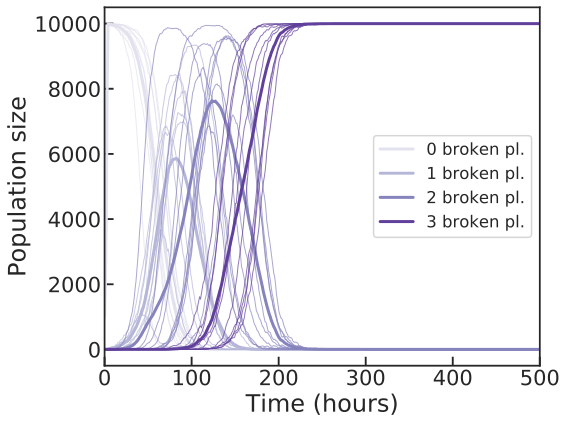

In [7]:
# plot the trajectories. 
plot_timecourse_stochastic_pops(pops, number_of_states, n_simulations,
                                time = time_points)

In [8]:
# Get the percentages from the populations 
percentages = get_percentages(pops, n_simulations, time_points, number_of_states)
# Calculate the three summary statistics and print them 
tau = get_tau(percentages, time_points)
omega = get_omega(percentages, time_points, number_of_states)
gamma = get_gamma(percentages, time_points)
print('Tau = ', tau)
print('Omega = ', omega)
print('Gamma = ', gamma)

Tau =  60.12024048096192
Omega =  98.19639278557113
Gamma =  158.31663326653305


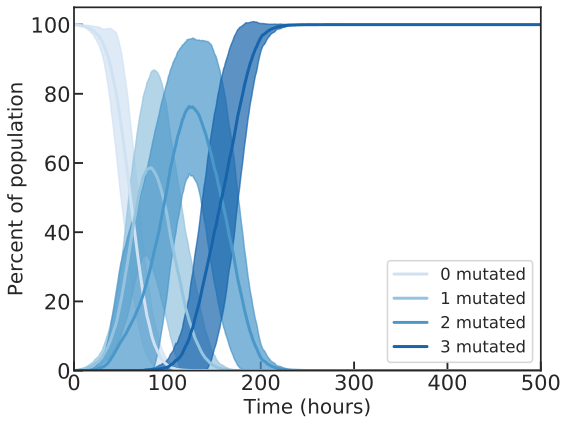

In [9]:
# Use the percentages data to plot the percentages 
plot_percentages(percentages, time_points, 4, "Blues")

While the code above is great for getting an intuition for how different parameter combinations generate different evolutionary trajectories, it's difficult to systematically vary parameters as each simulation run takes a couple of minutes. Below is code to run many simulations at once and then output summary statistics for each simulation run that can then be analyzed in "Analysis of stochastic partitioning simulations." 

In [10]:
def simulate_for_df(selection_modes, burdens, copy_numbers, mutation_rates, pop_sizes, 
                   partitionings, number_of_simulations, timepoints): 
    '''Requires a list of selection_modes, burdens, copy_numbers, mutation_rates, pop_sizes,
    partitionings, number_of_simulations, and timepoints. It then simulates all combinations
    of the parameters for the defined number_of_simulations for the specified durations.'''
    
    # Initialize the output dataframe
    all_sim_df = pd.DataFrame(columns = ['growth_rates', 'copy number',
                'mutation_rate', 'pop_size', 'partitioning', 'time',
                'gamma', 'tau'])
    
    # Iterate over each selection mode
    for selection_mode in selection_modes:
        # Iterate over each burden
        for burden in burdens: 
            # Iterate over each copy number
            for copy_number in copy_numbers:
                # Iterate over each mutation rate
                for mutation_rate in mutation_rates:
                    # Iterate over each population size
                    for pop_size in pop_sizes:
                        # Iterate over each partitioning 
                        for partitioning in partitionings:
                                # Get the growth_rates
                                growth_rates = selection_mode_and_copy_number_to_growth_rates(selection_mode, burden, copy_number)
                                # Get the pmf matrix
                                probability_matrix = hypergeom_pmf_matrix(copy_number)
                                # Get updates and rates
                                all_updates, all_rates = generate_update_rule_from_pmf(probability_matrix, growth_rates,
                                                                                      mutation_rate, partitioning)
                                # converts rates to an array
                                all_rates = np.array(all_rates, dtype=np.float64)
                                
                                # Set initial concentrations 
                                concentrations = [1] + [0]*(copy_number-1)
                                # Convert the concentrations to an array 
                                concs = np.array(concentrations, dtype=np.float64)
                                # Set the cutoff
                                cutoff = 0
                                
                                # Initialize the populations 
                                pops = np.zeros((1, len(time_points), copy_number))
                                
                                # Iterate over number of simulations
                                for i in range(number_of_simulations):
                                    # Perform gillespie SSA
                                    pops[0,:,:] = gillespie_ssa(concs, all_rates, all_updates, time_points, cutoff,
                                                                pop_threshold = pop_size)
                                    # Get percentages
                                    percentages = get_percentages(pops, 1, time_points, copy_number)
                                    
                                    # get tau, omega, gamma
                                    tau = get_tau(percentages, time_points)
                                    omega = get_omega(percentages, time_points, copy_number)
                                    gamma = get_gamma(percentages, time_points)
                                    
                                    # generate a list of timepoints
                                    tp_list = []
                                    for i in range(0, len(time_points)):
                                        tp_list.append(int(time_points[i]))
                                    
                                    # generate a list of pops
                                    pop_list = []
                                    for i in range(0, np.shape(pops)[1]):
                                        pop_list.append(pops[0][i])

                                    # data to add to dataframe
                                    thing_to_make_df = [selection_mode, growth_rates, copy_number, mutation_rate, pop_size, 
                                                        partitioning, timepoints[-1], tau, omega, gamma] + pop_list 
                                    # columns to add it to 
                                    columns_df = ['selection mode', 'growth_rates', 'copy number',
                                                            'mutation_rate', 'pop_size', 'partitioning', 'time',
                                                                     'tau', 'omega', 'gamma'] + tp_list
                                    
                                    # create a df for this simulation 
                                    sim_df =  pd.DataFrame([thing_to_make_df],
                                                           columns = columns_df)
                                    # Append sim_df to all_sim_df
                                    all_sim_df = all_sim_df.append(sim_df, sort=True)

    # return all_sim_df 
    return all_sim_df

In [11]:
# Specify what parameters you want to run 
selection_modes = ['additive']
burdens = [0.3]
copy_numbers  = [4]
mutation_rates = [1e-4]
pop_sizes = [1e4]
partitionings = [False, True]
number_of_simulations = 3
timepoints = np.linspace(0,1000,1000)

# Commented because this takes a long time to run, but here is an example of a larger
# set of parameters to simulate.
# selection_modes = ['dominant', 'additive', 'recessive']
# burdens = [0.03, 0.1, 0.3]
# copy_numbers  = [4, 11, 31]
# mutation_rates = [1e-6, 1e-5, 1e-4]
# pop_sizes = [1e4]
# partitionings = [False, True]
# number_of_simulations = 3
# time_points = np.linspace(0,2000,2000)

In [12]:
full_df = simulate_for_df(selection_modes, burdens, copy_numbers, mutation_rates, pop_sizes, 
                   partitionings, number_of_simulations, timepoints)

We can take a look at the output df and decide to save it for future analysis if we want. 

In [13]:
full_df

,copy number,gamma,growth_rates,mutation_rate,omega,partitioning,pop_size,selection mode,tau,time,...,490,491,492,493,494,495,496,497,498,500
0,4,159.318637,"[0.7, 0.7999999999999999, 0.9, 1.0]",0.0001,116.232465,False,10000.0,additive,77.154309,1000.0,...,"[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]"
0,4,164.328657,"[0.7, 0.7999999999999999, 0.9, 1.0]",0.0001,109.218437,False,10000.0,additive,74.148297,1000.0,...,"[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]"
0,4,134.268537,"[0.7, 0.7999999999999999, 0.9, 1.0]",0.0001,103.206413,False,10000.0,additive,68.136273,1000.0,...,"[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]"
0,4,39.078156,"[0.7, 0.7999999999999999, 0.9, 1.0]",0.0001,39.078156,True,10000.0,additive,39.078156,1000.0,...,"[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]"
0,4,34.068136,"[0.7, 0.7999999999999999, 0.9, 1.0]",0.0001,34.068136,True,10000.0,additive,33.066132,1000.0,...,"[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]"
0,4,48.096192,"[0.7, 0.7999999999999999, 0.9, 1.0]",0.0001,48.096192,True,10000.0,additive,47.094188,1000.0,...,"[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]","[0.0, 0.0, 0.0, 10000.0]"


The next notebook, Analysis of stochastic partitioning simulations, will focus on analyzing such an output file. 